# Testdaten zum Uploaden erstellen

In [10]:
import nilmtk
import os
import numpy as np

DATA_PATH = 'C:\\Users\\stefa\\OneDrive - FHWN\\Privat\\Studium\\MIT_2-Semester\\case_study\\lession1\\datasets\\ukdale2.h5'
building = 5
start_time = '2014-10-08'
end_time = '2014-10-11'
sample_period = 10

CSVPATH = f'app\\static\\uploads\\mains_{building}_{start_time}_{end_time}.csv'

ukdale = nilmtk.DataSet(DATA_PATH)
ukdale.set_window(start=start_time, end=end_time)
main = next(ukdale.buildings[1].elec.mains().load(sample_period=sample_period))
aggregate = main['power']['active']
aggregate.to_csv(CSVPATH,header=False)
aggregate.head(n=5)



2014-10-08 00:00:00+01:00    142.742004
2014-10-08 00:00:10+01:00    141.654541
2014-10-08 00:00:20+01:00    142.166992
2014-10-08 00:00:30+01:00    146.613327
2014-10-08 00:00:40+01:00    146.849091
Freq: 10S, Name: active, dtype: float32

In [76]:

# mains.to_csv('app\\static\\uploads\\mains.csv')
type(mains)
mains

2014-10-01 00:00:00+01:00    631.391968
2014-10-01 00:00:10+01:00    634.210999
2014-10-01 00:00:20+01:00    631.526978
2014-10-01 00:00:30+01:00    637.171997
2014-10-01 00:00:40+01:00    634.783020
                                ...    
2014-10-01 23:59:10+01:00    308.125000
2014-10-01 23:59:20+01:00    307.385010
2014-10-01 23:59:30+01:00    310.351013
2014-10-01 23:59:40+01:00    308.066010
2014-10-01 23:59:50+01:00    307.515015
Freq: 10S, Name: (power, active), Length: 8640, dtype: float32

In [285]:
import pandas as pd

mains = pd.read_csv(CSVPATH,header=None).rename(columns={0:'Date',1:'Power'})
mains['Date'] = pd.to_datetime(mains['Date'])
mains = mains.set_index('Date').iloc[:,0]
# type(mains)
mains


Date
2014-10-01 00:00:00+01:00    631.39197
2014-10-01 00:00:10+01:00    634.21100
2014-10-01 00:00:20+01:00    631.52700
2014-10-01 00:00:30+01:00    637.17200
2014-10-01 00:00:40+01:00    634.78300
                               ...    
2014-10-01 23:59:10+01:00    308.12500
2014-10-01 23:59:20+01:00    307.38500
2014-10-01 23:59:30+01:00    310.35100
2014-10-01 23:59:40+01:00    308.06600
2014-10-01 23:59:50+01:00    307.51500
Name: Power, Length: 8640, dtype: float64

-------------------------------------
# Predict

In [286]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.font_manager
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [293]:
DATA_PATH = 'C:\\Users\\stefa\\OneDrive - FHWN\\Privat\\Studium\\MIT_2-Semester\\case_study\\lession1\\datasets\\ukdale2.h5'
WEIGHTS_PATH = 'app\\weights\\seq2point-temp-weights-microwave-epoch0.h5'
WEIGHTS_PATH = 'app\\weights\\seq2point-temp-weights-microwave-epoch0.h5'
SAMPLE_PERIOD = 30

from nilmtk import DataSet

ukdale = DataSet(DATA_PATH)
ukdale.set_window(start='2014-04-01', end='2014-04-05')

main = next(ukdale.buildings[1].elec.mains().load(sample_period=SAMPLE_PERIOD))
aggregate = main['power']['active']
aggregate.head(n=5)

2014-04-01 00:00:00+01:00    292.490997
2014-04-01 00:00:30+01:00    293.072327
2014-04-01 00:01:00+01:00    294.752655
2014-04-01 00:01:30+01:00    291.221985
2014-04-01 00:02:00+01:00    291.251678
Freq: 30S, Name: active, dtype: float32

In [294]:
microwave = next(ukdale.buildings[1].elec['microwave'].load(sample_period=SAMPLE_PERIOD))
microwave.head(n=5)

physical_quantity,power
type,active
2014-04-01 00:00:00+01:00,1.0
2014-04-01 00:00:30+01:00,1.0
2014-04-01 00:01:00+01:00,1.0
2014-04-01 00:01:30+01:00,1.0
2014-04-01 00:02:00+01:00,1.0


In [295]:
def normalise(df):
    """
    Normalises the values in df
    """
    mean = df.fillna(method='ffill').values.mean()
    std = df.fillna(method = 'ffill').values.std()
    return mean, std, (df.fillna(method='ffill').values-mean)/std

mean_agg, std_agg, aggregate = normalise(aggregate)
mean_frz, std_frz, fridge = normalise(microwave)

In [296]:

WINDOW_SIZE =99
aggregate = np.pad(aggregate, (WINDOW_SIZE//2, WINDOW_SIZE//2 +1))
aggregate = np.array([aggregate[i:i+WINDOW_SIZE] for i in range(len(aggregate)-WINDOW_SIZE)])
aggregate = np.expand_dims(aggregate, axis=-1)
# aggregate

In [297]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense

def return_seq2point(sequence_length):
    model = Sequential()
    # 1D Conv
    model.add(Conv1D(30,10,activation="relu",input_shape=(sequence_length,1),strides=2))
    model.add(Conv1D(30, 8, activation='relu', strides=2))
    model.add(Conv1D(40, 6, activation='relu', strides=1))
    model.add(Conv1D(50, 5, activation='relu', strides=1))
    model.add(Dropout(.2))
    model.add(Conv1D(50, 5, activation='relu', strides=1))
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(sequence_length))
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=optim)
    return model
    
def return_seq2point():
    model = Sequential()
    model.add(Conv1D(30, 10, activation="relu", input_shape=(99, 1), strides=1))
    model.add(Conv1D(30, 8, activation='relu', strides=1))
    model.add(Conv1D(40, 6, activation='relu', strides=1))
    model.add(Conv1D(50, 5, activation='relu', strides=1))
    model.add(Dropout(.2))
    model.add(Conv1D(50, 5, activation='relu', strides=1))
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1))
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=optim)  # ,metrics=[mse])
    return model


In [299]:
microwave_model = return_seq2point()
microwave_model.load_weights(WEIGHTS_PATH)

In [300]:
y_predict = microwave_model.predict(aggregate)
y_predict

array([[7.029116 ],
       [6.8129168],
       [6.9482455],
       ...,
       [2.7808046],
       [3.8409483],
       [5.3931427]], dtype=float32)

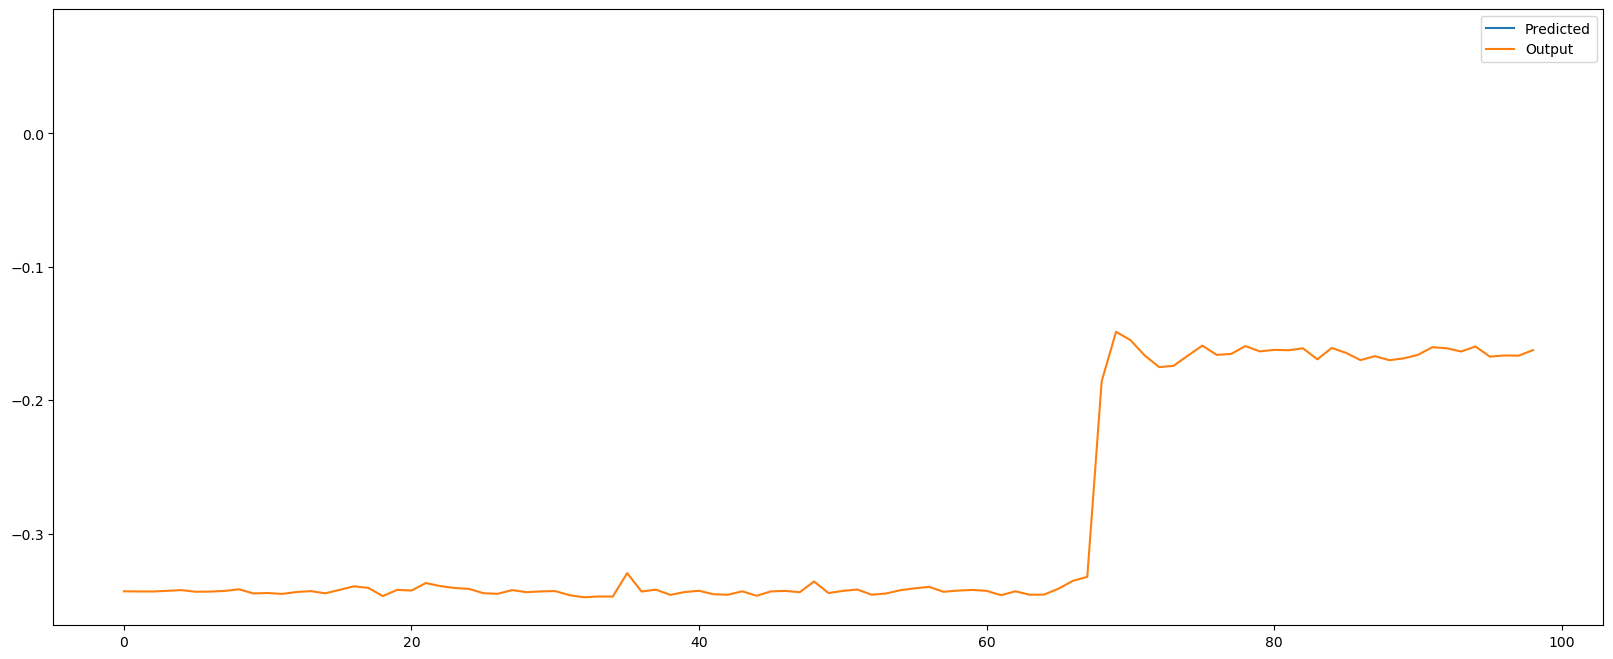

In [301]:
index = 150
predicted_seq = y_predict[index]
real_seq = aggregate[index]
figure(figsize=(20,8))
plt.plot(predicted_seq, label='Predicted')
plt.plot(real_seq, label='Output')
plt.legend()
plt.show()

In [284]:
def denormlise(array, mean, std):
    return array*std+mean

def aggregate_sequences(prediction):
    l = WINDOW_SIZE
    n = len(prediction) + l - 1
    sum_arr = np.zeros((n))
    counts_arr = np.zeros((n))
    o = len(sum_arr)
    for i in range(len(prediction)):
        sum_arr[i:i + l] += prediction[i].flatten()
        counts_arr[i:i + l] += 1
    for i in range(len(sum_arr)):
        sum_arr[i] = sum_arr[i] / counts_arr[i]
    return denormlise(sum_arr, mean_frz, std_frz)

y_predict = aggregate_sequences(y_predict)
y_real = aggregate_sequences(aggregate)

In [302]:
y_predict.shape


(11520, 1)

In [275]:
y_real.shape
y_real[0]

7.187527179718018

In [305]:
main.shape

(11520, 3)

[]

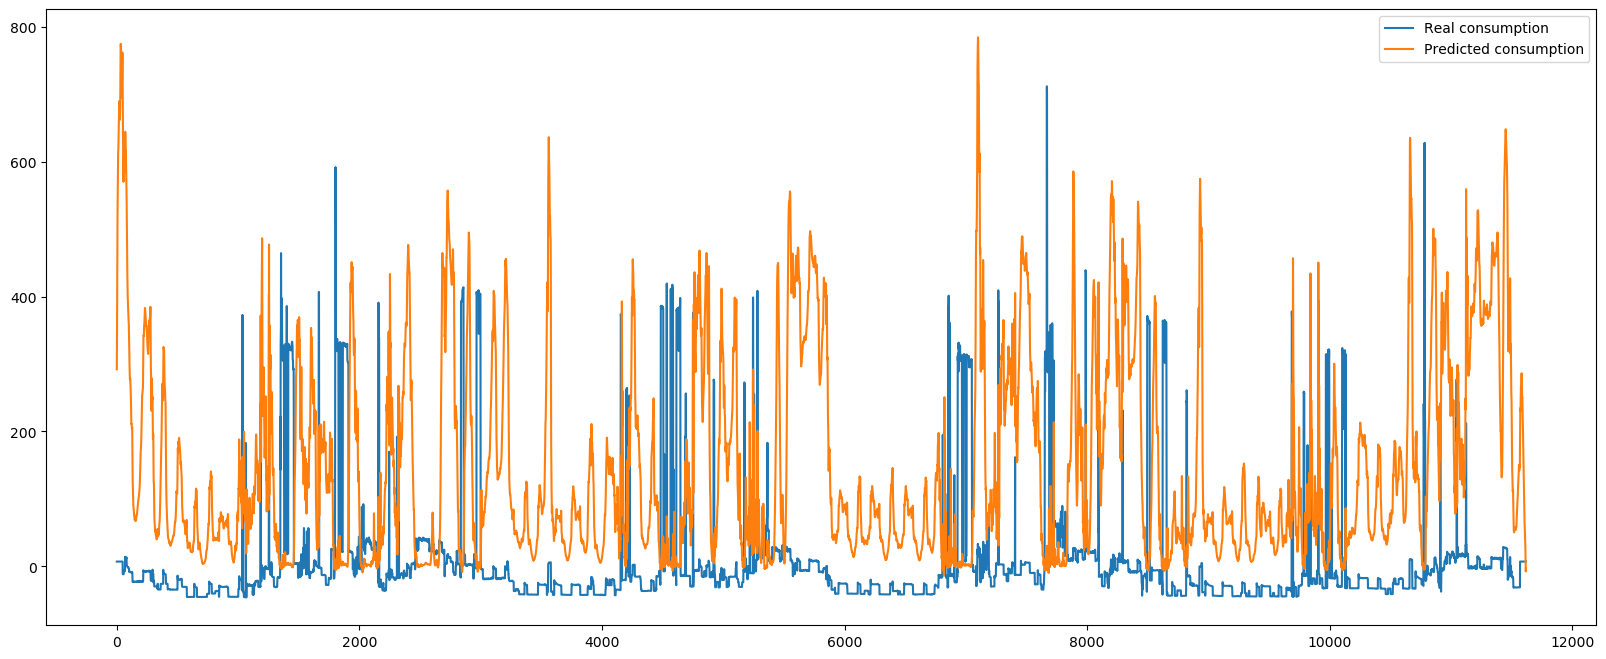

In [88]:
figure(figsize=(20,8))
plt.plot(y_real, label='Real consumption')
plt.plot(y_predict, label='Predicted consumption')
plt.legend()
plt.plot()

In [89]:
y_predict

array([292.12315373, 312.7786307 , 351.71569807, ...,   0.94919432,
        -7.37693237,  -3.51773356])

## Prod Test

In [335]:
SUPPORTED_APPLIANCES = {
    "washingmachine":{
        "name":"Washing Machine",
        "seq2point_weights":"seq2point-temp-weights-washing_machine-epoch0.h5"},
    "fridge":{
        "name":"Fridge",
        "seq2point_weights":"seq2point-temp-weights-fridge-epoch0.h5"},
    "microwave":{
        "name":"Microwave",
        "seq2point_weights":"seq2point-temp-weights-microwave-epoch0.h5"},
    "kettle":{
        "name":"Kettle",
        "seq2point_weights":"seq2point-temp-weights-kettle-epoch0.h5"}
        }
SAMPLE_PERIOD = 10
WINDOW_SIZE = 99

WEIGHTS_PATH = os.path.join(BASEDIR,"app","weights",SUPPORTED_APPLIANCES[appliance]['seq2point_weights'])


data = pd.read_csv(CSVPATH,header=None).rename(columns={0:'Date',1:'Power'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
# data
aggregate2 = data['Power']
aggregate2.head(n=5)


Date
2014-10-01 00:00:00+01:00    631.39197
2014-10-01 00:00:10+01:00    634.21100
2014-10-01 00:00:20+01:00    631.52700
2014-10-01 00:00:30+01:00    637.17200
2014-10-01 00:00:40+01:00    634.78300
Name: Power, dtype: float64

In [336]:
mean_agg, std_agg, aggregate2 = normalise(aggregate2)

aggregate2 = np.pad(aggregate2, (WINDOW_SIZE//2, WINDOW_SIZE//2 +1))
aggregate2 = np.array([aggregate2[i:i+WINDOW_SIZE] for i in range(len(aggregate2)-WINDOW_SIZE)])
aggregate2 = np.expand_dims(aggregate2, axis=-1)
# aggregate2

In [337]:
WEIGHTS_PATH
model = return_seq2point()

model.load_weights(WEIGHTS_PATH)
predict = model.predict(aggregate2)
predict



array([[9.186958 ],
       [9.305565 ],
       [9.657299 ],
       ...,
       [0.9065353],
       [1.2201811],
       [2.5896907]], dtype=float32)

In [339]:
predict.shape

(8640, 1)

In [340]:
data['micorwave'] = np.squeeze(predict)
data

,Power,micorwave
Date,,
2014-10-01 00:00:00+01:00,631.39197,9.186958
2014-10-01 00:00:10+01:00,634.21100,9.305565
2014-10-01 00:00:20+01:00,631.52700,9.657299
2014-10-01 00:00:30+01:00,637.17200,9.739818
2014-10-01 00:00:40+01:00,634.78300,10.306221
...,...,...
2014-10-01 23:59:10+01:00,308.12500,0.786897
2014-10-01 23:59:20+01:00,307.38500,0.942663
2014-10-01 23:59:30+01:00,310.35100,0.906535


In [320]:
figure(figsize=(20,8))
plt.plot(data, label='Real consumption')
plt.plot(predict, label='Predicted consumption')
plt.legend()
plt.plot()

c:\Users\stefa\.conda\envs\casestudy2\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


[]

ValueError: view limit minimum -36775.39791087963 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 2000x800 with 1 Axes>

In [351]:
df = pd.read_csv(os.path.join(BASEDIR,"app","static","uploads","20230605-212139_prediction.csv"))
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
hourly_sum = df[appliance].resample('H').sum()
hourly_sum.index = hourly_sum.index.strftime('%Y-%m-%d %H:%M')

labels = hourly_sum.index.to_list()
values = hourly_sum.values.tolist()
mean = round(hourly_sum.values.mean()/1000,2)
bills = round(hourly_sum.values.sum()*0.008/12,2)

In [353]:
values

[2925.9400418699965,
 71.99177912999998,
 -22.818912722999986,
 -22.814942659000003,
 -22.815923698000024,
 -22.90332115199999,
 1066.4277838293988,
 21.510722057230005,
 3137.8883907670006,
 3449.866563125198,
 3783.251057000002,
 3815.8489554999983,
 3574.4796244600007,
 495.6723743736601,
 492.7066513042999,
 1843.2782275386996,
 628.9573048165001,
 327.1761680611595,
 -12.494023773,
 -15.225484655999999,
 881.3324680714998,
 2168.8347454377977,
 0.04304680645999791,
 -13.231503270999994]